In [2]:
# =============================================================================
# Cell 1: Import Required Libraries
# =============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier 
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.utils.class_weight import compute_class_weight
import warnings
warnings.filterwarnings('ignore')

In [3]:
# =============================================================================
# Load Data from existing feature-engineering files
# =============================================================================

try:
    # Try to load the previously saved splits
    with open('../src/models/train_test_splits.pkl', 'rb') as f:
        splits = pickle.load(f)

    with open('../src/models/feature_info.pkl', 'rb') as f:
        feature_info = pickle.load(f)

    print("✅ Successfully loaded existing feature-engineering artefacts")

    # Use the combined feature set (TF-IDF + numerical)
    X_train = splits['combined']['X_train']
    X_test  = splits['combined']['X_test']
    y_train = splits['combined']['y_train']
    y_test  = splits['combined']['y_test']

except FileNotFoundError:
    print("⚠️  Feature-engineering files not found!")
    
print(f"Training samples: {X_train.shape[0]}")
print(f"Test samples: {X_test.shape[0]}")
print(f"Features: {X_train.shape[1]}")

✅ Successfully loaded existing feature-engineering artefacts
Training samples: 10978
Test samples: 2745
Features: 5011


In [ ]:
# =============================================================================
# CLASS IMBALANCE ANALYSIS
# =============================================================================
import numpy as np
import pandas as pd
from sklearn.utils.class_weight import compute_class_weight

print("\nCLASS IMBALANCE ANALYSIS")
print("=" * 30)

# Count samples per class
class_counts = pd.Series(y_train).value_counts().sort_index()
total = len(y_train)

print("Star-rating distribution:")
for star, count in class_counts.items():
    percent = (count / total) * 100
    print(f"{star}⭐ : {count:5d} ({percent:5.1f} %)")

# Compute class weights (useful for imbalanced learning)
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
weight_dict = dict(zip(np.unique(y_train), class_weights))

print("\nComputed class-weights:")
for star, weight in weight_dict.items():
    print(f"{star}⭐ : {weight:.3f}")


CLASS IMBALANCE ANALYSE:
Sternenbewertung Verteilung:
1⭐:  5736 ( 52.2%)
2⭐:   697 (  6.3%)
3⭐:   518 (  4.7%)
4⭐:   891 (  8.1%)
5⭐:  3136 ( 28.6%)

Class Weights für Balancing:
1⭐: 0.383
2⭐: 3.150
3⭐: 4.239
4⭐: 2.464
5⭐: 0.700


In [5]:
# =============================================================================
# EVALUATION FUNCTIONS
# =============================================================================

def evaluate_classifier(model, X_train, X_test, y_train, y_test, model_name):
    """
    Umfassende Evaluation eines Classification Models
    """
    # Model trainieren
    model.fit(X_train, y_train)
    
    # Vorhersagen
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    # Wahrscheinlichkeiten (falls verfügbar)
    try:
        y_proba_test = model.predict_proba(X_test)
    except:
        y_proba_test = None
    
    # Metriken berechnen
    train_acc = accuracy_score(y_train, y_pred_train)
    test_acc = accuracy_score(y_test, y_pred_test)
    
    # Precision, Recall, F1 für jede Klasse
    precision, recall, f1, support = precision_recall_fscore_support(y_test, y_pred_test, average='weighted')
    
    # Macro averages (gleiche Gewichtung aller Klassen)
    macro_precision, macro_recall, macro_f1, _ = precision_recall_fscore_support(y_test, y_pred_test, average='macro')
    
    results = {
        'model_name': model_name,
        'train_accuracy': train_acc,
        'test_accuracy': test_acc,
        'weighted_precision': precision,
        'weighted_recall': recall,
        'weighted_f1': f1,
        'macro_precision': macro_precision,
        'macro_recall': macro_recall,
        'macro_f1': macro_f1,
        'predictions': y_pred_test,
        'probabilities': y_proba_test
    }
    
    return results

def plot_confusion_matrix(y_true, y_pred, model_name):
    """Plot Confusion Matrix"""
    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=[f'{i}⭐' for i in range(1, 6)],
                yticklabels=[f'{i}⭐' for i in range(1, 6)])
    plt.title(f'Confusion Matrix - {model_name}')
    plt.xlabel('Vorhergesagte Sterne')
    plt.ylabel('Tatsächliche Sterne')
    plt.show()

In [6]:
# =============================================================================
# 1. LOGISTIC REGRESSION (Baseline)
# =============================================================================

print("\n" + "="*50)
print("1. LOGISTIC REGRESSION (Baseline)")
print("="*50)

# Mit Class Weight Balancing
lr_model = LogisticRegression(
    class_weight='balanced',
    max_iter=1000,
    random_state=42,
    multi_class='ovr'  # One-vs-Rest für multi-class
)

lr_results = evaluate_classifier(lr_model, X_train, X_test, y_train, y_test, "Logistic Regression")

print(f"Test Accuracy: {lr_results['test_accuracy']:.3f}")
print(f"Weighted F1: {lr_results['weighted_f1']:.3f}")
print(f"Macro F1: {lr_results['macro_f1']:.3f}")

print("\n✅ WARUM LOGISTIC REGRESSION:")
print("- Schnell und interpretierbar")
print("- Gut für Text-Features (TF-IDF)")
print("- Liefert Wahrscheinlichkeiten")
print("- Baseline für Vergleich")


1. LOGISTIC REGRESSION (Baseline)
Test Accuracy: 0.713
Weighted F1: 0.715
Macro F1: 0.448

✅ WARUM LOGISTIC REGRESSION:
- Schnell und interpretierbar
- Gut für Text-Features (TF-IDF)
- Liefert Wahrscheinlichkeiten
- Baseline für Vergleich


In [7]:
# =============================================================================
# 2. RANDOM FOREST CLASSIFIER
# =============================================================================

print("\n" + "="*50)
print("2. RANDOM FOREST CLASSIFIER")
print("="*50)

rf_model = RandomForestClassifier(
    n_estimators=100,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

rf_results = evaluate_classifier(rf_model, X_train, X_test, y_train, y_test, "Random Forest")

print(f"Test Accuracy: {rf_results['test_accuracy']:.3f}")
print(f"Weighted F1: {rf_results['weighted_f1']:.3f}")
print(f"Macro F1: {rf_results['macro_f1']:.3f}")

print("\n✅ WARUM RANDOM FOREST:")
print("- Robust gegen Overfitting")
print("- Handhabt gemischte Features gut")
print("- Feature Importance verfügbar")
print("- Wenig Hyperparameter Tuning nötig")


2. RANDOM FOREST CLASSIFIER
Test Accuracy: 0.729
Weighted F1: 0.651
Macro F1: 0.318

✅ WARUM RANDOM FOREST:
- Robust gegen Overfitting
- Handhabt gemischte Features gut
- Feature Importance verfügbar
- Wenig Hyperparameter Tuning nötig


In [8]:
# =============================================================================
# 3. XGBOOST CLASSIFIER 
# =============================================================================

print("\n" + "="*50)
print("3. XGBOOST CLASSIFIER")
print("="*50)

# XGBoost Model initialisieren
xgb_model = XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    random_state=42,
    eval_metric='mlogloss',
    use_label_encoder=False
)

# Labels für XGBoost vorbereiten (0-4 statt 1-5)
y_train_enc = pd.Series(y_train).astype(int) - 1  # 0–4
y_test_enc  = pd.Series(y_test ).astype(int) - 1  # 0–4

# Class weights berechnen
freq = pd.Series(y_train_enc).value_counts(normalize=True)
weight_dict = (1 / freq).to_dict()
sample_weights = np.array([weight_dict[v] for v in y_train_enc])

# XGBoost mit korrekten Parametern trainieren
# WICHTIG: X_train als Features, y_train_enc als Labels!
xgb_model.fit(X_train, y_train_enc, sample_weight=sample_weights)

# Predictions
y_pred_test = xgb_model.predict(X_test)
y_pred_train = xgb_model.predict(X_train)

# Ergebnisse sammeln
xgb_results = {
    'model_name': 'XGBoost',
    'train_accuracy': accuracy_score(y_train_enc, y_pred_train),
    'test_accuracy': accuracy_score(y_test_enc, y_pred_test),
    'predictions': y_pred_test
}

# F1 Scores berechnen
precision, recall, f1, _ = precision_recall_fscore_support(y_test_enc, y_pred_test, average='weighted')
macro_precision, macro_recall, macro_f1, _ = precision_recall_fscore_support(y_test_enc, y_pred_test, average='macro')

xgb_results.update({
    'weighted_f1': f1,
    'macro_f1': macro_f1,
    'weighted_precision': precision,
    'weighted_recall': recall,
    'macro_precision': macro_precision,
    'macro_recall': macro_recall
})

print(f"Test Accuracy: {xgb_results['test_accuracy']:.3f}")
print(f"Weighted F1: {xgb_results['weighted_f1']:.3f}")
print(f"Macro F1: {xgb_results['macro_f1']:.3f}")

print("\n✅ WARUM XGBOOST:")
print("- Oft beste Performance")
print("- Handhabt Imbalanced Data gut")
print("- Regularization eingebaut")
print("- Sehr flexibel und robust")


3. XGBOOST CLASSIFIER
Test Accuracy: 0.663
Weighted F1: 0.678
Macro F1: 0.431

✅ WARUM XGBOOST:
- Oft beste Performance
- Handhabt Imbalanced Data gut
- Regularization eingebaut
- Sehr flexibel und robust


In [9]:
# =============================================================================
# 4. SUPPORT VECTOR CLASSIFIER (SVC)
# =============================================================================

print("\n" + "="*50)
print("4. LINEAR SUPPORT VECTOR CLASSIFIER")
print("="*50)

from sklearn.svm import LinearSVC

# LinearSVC ist fast immer die bessere Wahl für linear separable Daten
svc_model = LinearSVC(
    C=1.0,
    class_weight='balanced',
    random_state=42,
    max_iter=2000,
    dual='auto'  # Automatische Optimierung basierend auf Datenform
)

svc_results = evaluate_classifier(svc_model, X_train, X_test, y_train, y_test, "LinearSVC")

print(f"Test Accuracy: {svc_results['test_accuracy']:.3f}")
print(f"Weighted F1: {svc_results['weighted_f1']:.3f}")
print(f"Macro F1: {svc_results['macro_f1']:.3f}")


print("\n✅ WARUM SVC:")
print("- Effektiv bei hochdimensionalen Daten")
print("- Gut für Text-Classification")
print("- Memory efficient")
print("- Robuste Decision Boundaries")


4. LINEAR SUPPORT VECTOR CLASSIFIER
Test Accuracy: 0.698
Weighted F1: 0.695
Macro F1: 0.419

✅ WARUM SVC:
- Effektiv bei hochdimensionalen Daten
- Gut für Text-Classification
- Memory efficient
- Robuste Decision Boundaries


In [10]:
# =============================================================================
# 5. NAIVE BAYES CLASSIFIER
# =============================================================================
from sklearn.naive_bayes import GaussianNB
from scipy import sparse
import numpy as np

print("\n" + "="*50)
print("5. NAIVE BAYES CLASSIFIER")
print("="*50)

# GaussianNB benötigt dense arrays
nb_model = GaussianNB()

# Konvertiere sparse zu dense falls nötig
print("📊 Konvertiere sparse Matrix zu dense Array...")
if sparse.issparse(X_train):
    X_train_dense = X_train.toarray()
    print(f"   X_train shape: {X_train_dense.shape}")
else:
    X_train_dense = X_train

if sparse.issparse(X_test):
    X_test_dense = X_test.toarray()
    print(f"   X_test shape: {X_test_dense.shape}")
else:
    X_test_dense = X_test

print("✅ Konvertierung abgeschlossen!")

nb_results = evaluate_classifier(nb_model, X_train_dense, X_test_dense, y_train, y_test, "Gaussian Naive Bayes")

print(f"Test Accuracy: {nb_results['test_accuracy']:.3f}")
print(f"Weighted F1: {nb_results['weighted_f1']:.3f}")
print(f"Macro F1: {nb_results['macro_f1']:.3f}")

print("\n✅ WARUM GAUSSIAN NAIVE BAYES:")
print("- Sehr schnell")
print("- Wenig Daten nötig")
print("- Nimmt Normalverteilung der Features an")
print("- Kann negative Werte verarbeiten")
print("- Probabilistische Vorhersagen")



5. NAIVE BAYES CLASSIFIER
📊 Konvertiere sparse Matrix zu dense Array...
   X_train shape: (10978, 5011)
   X_test shape: (2745, 5011)
✅ Konvertierung abgeschlossen!
Test Accuracy: 0.472
Weighted F1: 0.523
Macro F1: 0.308

✅ WARUM GAUSSIAN NAIVE BAYES:
- Sehr schnell
- Wenig Daten nötig
- Nimmt Normalverteilung der Features an
- Kann negative Werte verarbeiten
- Probabilistische Vorhersagen


In [11]:
# =============================================================================
# 6. GRADIENT BOOSTING CLASSIFIER
# =============================================================================

print("\n" + "="*50)
print("6. GRADIENT BOOSTING CLASSIFIER")
print("="*50)

gb_model = GradientBoostingClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    random_state=42
)

gb_results = evaluate_classifier(gb_model, X_train, X_test, y_train, y_test, "Gradient Boosting")

print(f"Test Accuracy: {gb_results['test_accuracy']:.3f}")
print(f"Weighted F1: {gb_results['weighted_f1']:.3f}")
print(f"Macro F1: {gb_results['macro_f1']:.3f}")

print("\n✅ WARUM GRADIENT BOOSTING:")
print("- Iterative Verbesserung")
print("- Gut für komplexe Patterns")
print("- Weniger Overfitting als einzelne Trees")
print("- Feature Importance")


6. GRADIENT BOOSTING CLASSIFIER
Test Accuracy: 0.738
Weighted F1: 0.675
Macro F1: 0.361

✅ WARUM GRADIENT BOOSTING:
- Iterative Verbesserung
- Gut für komplexe Patterns
- Weniger Overfitting als einzelne Trees
- Feature Importance


In [12]:
# =============================================================================
# 7. K-NEAREST NEIGHBORS (KNN)
# =============================================================================

print("\n" + "="*50)
print("7. K-NEAREST NEIGHBORS (KNN)")
print("="*50)

from sklearn.neighbors import KNeighborsClassifier

# KNN mit optimalen Parametern
knn_model = KNeighborsClassifier(
    n_neighbors=5,
    weights='distance',  # Gewichtung nach Distanz
    metric='cosine',     # Gut für Text-Features
    n_jobs=-1
)

knn_results = evaluate_classifier(knn_model, X_train, X_test, y_train, y_test, "KNN")

print(f"Test Accuracy: {knn_results['test_accuracy']:.3f}")
print(f"Weighted F1: {knn_results['weighted_f1']:.3f}")
print(f"Macro F1: {knn_results['macro_f1']:.3f}")

print("\n✅ WARUM KNN:")
print("- Keine Annahmen über Datenverteilung")
print("- Gut für lokale Patterns")
print("- Interpretierbar durch Nachbarn")
print("- Effektiv bei ähnlichen Text-Features")


7. K-NEAREST NEIGHBORS (KNN)
Test Accuracy: 0.664
Weighted F1: 0.618
Macro F1: 0.327

✅ WARUM KNN:
- Keine Annahmen über Datenverteilung
- Gut für lokale Patterns
- Interpretierbar durch Nachbarn
- Effektiv bei ähnlichen Text-Features


In [13]:
# =============================================================================
# 8. DECISION TREE CLASSIFIER
# =============================================================================

print("\n" + "="*50)
print("8. DECISION TREE CLASSIFIER")
print("="*50)

from sklearn.tree import DecisionTreeClassifier

dt_model = DecisionTreeClassifier(
    max_depth=10,
    min_samples_split=20,
    min_samples_leaf=10,
    class_weight='balanced',
    random_state=42
)

dt_results = evaluate_classifier(dt_model, X_train, X_test, y_train, y_test, "Decision Tree")

print(f"Test Accuracy: {dt_results['test_accuracy']:.3f}")
print(f"Weighted F1: {dt_results['weighted_f1']:.3f}")
print(f"Macro F1: {dt_results['macro_f1']:.3f}")

print("\n✅ WARUM DECISION TREE:")
print("- Extrem interpretierbar")
print("- Explizite Entscheidungsregeln")
print("- Gut für Feature Importance")
print("- Baseline für Tree-Ensemble")

# Feature Importance anzeigen (falls verfügbar)
if hasattr(dt_model, 'feature_importances_'):
    print("\n📊 TOP 5 WICHTIGSTE FEATURES:")
    if 'feature_info' in locals():
        feature_names = feature_info.get('feature_names', [f'feature_{i}' for i in range(len(dt_model.feature_importances_))])
    else:
        feature_names = [f'feature_{i}' for i in range(len(dt_model.feature_importances_))]
    
    importances = dt_model.feature_importances_
    indices = np.argsort(importances)[::-1][:5]
    
    for i, idx in enumerate(indices):
        print(f"{i+1}. {feature_names[idx]}: {importances[idx]:.4f}")


8. DECISION TREE CLASSIFIER
Test Accuracy: 0.387
Weighted F1: 0.465
Macro F1: 0.300

✅ WARUM DECISION TREE:
- Extrem interpretierbar
- Explizite Entscheidungsregeln
- Gut für Feature Importance
- Baseline für Tree-Ensemble

📊 TOP 5 WICHTIGSTE FEATURES:
1. feature_5009: 0.2468
2. feature_5010: 0.1018
3. feature_5003: 0.0418
4. feature_5007: 0.0414
5. feature_5006: 0.0373


In [14]:
# =============================================================================
# 9. VOTING CLASSIFIER (ENSEMBLE)
# =============================================================================

print("\n" + "="*50)
print("9. VOTING CLASSIFIER (ENSEMBLE)")
print("="*50)

from sklearn.ensemble import VotingClassifier
from sklearn.calibration import CalibratedClassifierCV

# LinearSVC hat kein predict_proba, also kalibrieren
calibrated_lsvc = CalibratedClassifierCV(LinearSVC(class_weight='balanced', random_state=42, max_iter=500, dual=False))

# Beste Models für Ensemble auswählen
voting_models = [
    ('rf', RandomForestClassifier(n_estimators=50, class_weight='balanced', random_state=42)),
    ('xgb', XGBClassifier(n_estimators=50, learning_rate=0.2, random_state=42, eval_metric='mlogloss', use_label_encoder=False, n_jobs=2)),
    ('lr', LogisticRegression(class_weight='balanced', max_iter=500, random_state=42, n_jobs=2)),
    ('lsvc', calibrated_lsvc),
]

# Hard Voting
hard_voting = VotingClassifier(
    estimators=voting_models,
    voting='hard',
    n_jobs=-1
)

hard_voting_results = evaluate_classifier(hard_voting, X_train, X_test, y_train, y_test, "Hard Voting")

print(f"HARD VOTING:")
print(f"Test Accuracy: {hard_voting_results['test_accuracy']:.3f}")
print(f"Weighted F1: {hard_voting_results['weighted_f1']:.3f}")
print(f"Macro F1: {hard_voting_results['macro_f1']:.3f}")

# Soft Voting (mit Wahrscheinlichkeiten)
soft_voting = VotingClassifier(
    estimators=voting_models,
    voting='soft',
    n_jobs=-1
)

soft_voting_results = evaluate_classifier(soft_voting, X_train, X_test, y_train, y_test, "Soft Voting")

print(f"\nSOFT VOTING:")
print(f"Test Accuracy: {soft_voting_results['test_accuracy']:.3f}")
print(f"Weighted F1: {soft_voting_results['weighted_f1']:.3f}")
print(f"Macro F1: {soft_voting_results['macro_f1']:.3f}")

print("\n✅ WARUM VOTING CLASSIFIER:")
print("- Kombiniert Stärken verschiedener Models")
print("- Reduziert Overfitting")
print("- Oft 2-5% bessere Performance")
print("- Soft Voting nutzt Wahrscheinlichkeiten")


9. VOTING CLASSIFIER (ENSEMBLE)
HARD VOTING:
Test Accuracy: 0.752
Weighted F1: 0.687
Macro F1: 0.368

SOFT VOTING:
Test Accuracy: 0.762
Weighted F1: 0.693
Macro F1: 0.366

✅ WARUM VOTING CLASSIFIER:
- Kombiniert Stärken verschiedener Models
- Reduziert Overfitting
- Oft 2-5% bessere Performance
- Soft Voting nutzt Wahrscheinlichkeiten


In [15]:
# =============================================================================
# 10. STACKING CLASSIFIER (ADVANCED ENSEMBLE) - OPTIMIERT
# =============================================================================

print("\n" + "="*50)
print("10. STACKING CLASSIFIER (ADVANCED) - OPTIMIERT")
print("="*50)

from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.calibration import CalibratedClassifierCV
import time

print("📊 Konvertiere sparse Matrix zu dense Array für Stacking...")
if sparse.issparse(X_train):
    X_train_dense = X_train.toarray()
    X_test_dense = X_test.toarray()
    print(f"   Konvertiert: {X_train.shape} → {X_train_dense.shape}")
else:
    X_train_dense = X_train
    X_test_dense = X_test

# OPTIMIERUNG 1: Schnellere Base Models (alle arbeiten mit dense)
base_models = [
    # Weniger Bäume, begrenzte Tiefe
    ('rf', RandomForestClassifier(n_estimators=30, max_depth=8, class_weight='balanced', 
                                random_state=42, n_jobs=2)),
    
    # Weniger XGB Estimators, höhere Learning Rate
    ('xgb', XGBClassifier(n_estimators=30, learning_rate=0.2, max_depth=4, 
                         random_state=42, eval_metric='mlogloss', use_label_encoder=False, n_jobs=2)),
    
    # SVM durch schnellere LinearSVC ersetzen
    ('lsvc', CalibratedClassifierCV(
        LinearSVC(class_weight='balanced', random_state=42, max_iter=500, dual=False), cv=3)),
    
    # GaussianNB braucht dense Arrays
    ('nb', GaussianNB())  # GaussianNB für dense arrays
]

# OPTIMIERUNG 2: Schnellerer Meta-Model
meta_model = LogisticRegression(class_weight='balanced', random_state=42)

print("🚀 Training Optimized Stacking Classifier...")
start_time = time.time()

stacking_classifier = StackingClassifier(
    estimators=base_models,
    final_estimator=meta_model,
    cv=3,  # Weniger CV Folds (3 statt 5) → 40% schneller
    n_jobs=-1,
    passthrough=False  # Keine Original Features → schneller
)

stacking_results = evaluate_classifier(stacking_classifier, X_train_dense, X_test_dense, y_train, y_test, "Stacking")

training_time = time.time() - start_time
print(f"\n⏱️  Training Zeit: {training_time:.2f} Sekunden")

print(f"\nSTACKING RESULTS:")
print(f"Test Accuracy: {stacking_results['test_accuracy']:.3f}")
print(f"Weighted F1: {stacking_results['weighted_f1']:.3f}")
print(f"Macro F1: {stacking_results['macro_f1']:.3f}")

print("\n✅ WARUM STACKING:")
print("- Meta-Learning Ansatz")
print("- Lernt optimale Kombination")
print("- Oft beste Performance")
print("- Professioneller Standard")



10. STACKING CLASSIFIER (ADVANCED) - OPTIMIERT
📊 Konvertiere sparse Matrix zu dense Array für Stacking...
   Konvertiert: (10978, 5011) → (10978, 5011)
🚀 Training Optimized Stacking Classifier...

⏱️  Training Zeit: 228.74 Sekunden

STACKING RESULTS:
Test Accuracy: 0.640
Weighted F1: 0.687
Macro F1: 0.450

✅ WARUM STACKING:
- Meta-Learning Ansatz
- Lernt optimale Kombination
- Oft beste Performance
- Professioneller Standard


In [16]:
from sklearn.ensemble    import StackingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV
from sklearn.svm         import LinearSVC
from xgboost             import XGBClassifier
from sklearn.model_selection import StratifiedKFold
from scipy import sparse
import numpy as np, time

print("\n" + "="*50)
print("10. STACKING CLASSIFIER – ohne Naive Bayes (kein Negativ-Fehler)")
print("="*50)

# -------------------------------------------------------------------------
# 1) Dense-Arrays erstellen (float32)
# -------------------------------------------------------------------------
if sparse.issparse(X_train):
    X_train_dense = X_train.astype(np.float32).toarray()
    X_test_dense  = X_test.astype(np.float32).toarray()
else:
    X_train_dense = X_train.astype(np.float32)
    X_test_dense  = X_test.astype(np.float32)

# -------------------------------------------------------------------------
# 2) Base-Modelle (alle class_weight='balanced' / 'balanced_subsample')
# -------------------------------------------------------------------------
base_models = [
    ('rf', RandomForestClassifier(
        n_estimators=60, max_depth=10,
        class_weight='balanced_subsample',
        n_jobs=-1, random_state=42)),
    
    ('et', ExtraTreesClassifier(
        n_estimators=60, max_depth=10,
        class_weight='balanced',
        n_jobs=-1, random_state=42)),
    
    ('xgb', XGBClassifier(
        n_estimators=60, learning_rate=0.15, max_depth=5,
        subsample=0.8, colsample_bytree=0.8,
        objective='multi:softprob', num_class=len(np.unique(y_train)),
        eval_metric='mlogloss', n_jobs=2, random_state=42)),
    
    ('lsvc', CalibratedClassifierCV(
        estimator=LinearSVC(class_weight='balanced', random_state=42,
                            dual=False, max_iter=600),
        cv=3, n_jobs=-1))
]

# -------------------------------------------------------------------------
# 3) Meta-Lerner
# -------------------------------------------------------------------------
meta_model = LogisticRegression(max_iter=1000, class_weight='balanced',
                                solver='lbfgs', n_jobs=-1, random_state=42)

# -------------------------------------------------------------------------
# 4) Stacking-Classifier
# -------------------------------------------------------------------------
stacking_clf = StackingClassifier(
    estimators      = base_models,
    final_estimator = meta_model,
    passthrough     = True,    # Base-Outputs + Original-Features
    cv              = StratifiedKFold(n_splits=4, shuffle=True, random_state=42),
    n_jobs          = -1
)

# -------------------------------------------------------------------------
# 5) Training & Evaluation
# -------------------------------------------------------------------------
print("🚀 Training …")
t0 = time.time()
stack_results = evaluate_classifier(
    stacking_clf,
    X_train_dense, X_test_dense,
    y_train, y_test,
    model_name="Stacking (no NB)"
)
print(f"⏱  Trainingsdauer: {time.time()-t0:.1f} s")

print("\nSTACKING (no NB) – RESULTS")
print(f"Accuracy   : {stack_results['test_accuracy']:.3f}")
print(f"Weighted F1: {stack_results['weighted_f1']:.3f}")
print(f"Macro F1   : {stack_results['macro_f1']:.3f}")


10. STACKING CLASSIFIER – ohne Naive Bayes (kein Negativ-Fehler)
🚀 Training …
⏱  Trainingsdauer: 401.8 s

STACKING (no NB) – RESULTS
Accuracy   : 0.677
Weighted F1: 0.705
Macro F1   : 0.460


In [ ]:
from sklearn.ensemble    import StackingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV
from sklearn.svm         import LinearSVC
from xgboost             import XGBClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from scipy import sparse
import numpy as np, time

print("\n" + "="*50)
print("10. OPTIMIERTER STACKING CLASSIFIER für besseren Macro F1")
print("="*50)

# -------------------------------------------------------------------------
# 1) Dense-Arrays erstellen (float32) + Feature Scaling
# -------------------------------------------------------------------------
if sparse.issparse(X_train):
    X_train_dense = X_train.astype(np.float32).toarray()
    X_test_dense  = X_test.astype(np.float32).toarray()
else:
    X_train_dense = X_train.astype(np.float32)
    X_test_dense  = X_test.astype(np.float32)

# Standardisierung für SVM und Logistic Regression
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_dense)
X_test_scaled = scaler.transform(X_test_dense)

# -------------------------------------------------------------------------
# 2) Erweiterte Base-Modelle mit besserer Diversität
# -------------------------------------------------------------------------
base_models = [
    # Random Forest mit mehr Diversität
    ('rf', RandomForestClassifier(
        n_estimators=100, max_depth=12, min_samples_split=5, min_samples_leaf=2,
        class_weight='balanced_subsample', max_features='sqrt',  
        bootstrap=True, oob_score=True,
        n_jobs=-1, random_state=42)),
    
    # Extra Trees mit unterschiedlichen Parametern
    ('et', ExtraTreesClassifier(
        n_estimators=100, max_depth=15, min_samples_split=3, min_samples_leaf=1,
        class_weight='balanced', max_features='log2',
        bootstrap=False,
        n_jobs=-1, random_state=42)),
    
    # XGBoost mit Regularisierung und Scale-pos-weight
    ('xgb', XGBClassifier(
        n_estimators=100, learning_rate=0.1, max_depth=6,
        subsample=0.8, colsample_bytree=0.8, colsample_bylevel=0.8,
        reg_alpha=0.1, reg_lambda=1.0,  # L1/L2 Regularisierung
        scale_pos_weight=1,  # Wird automatisch für Multiclass angepasst
        objective='multi:softprob', num_class=len(np.unique(y_train)),
        eval_metric='mlogloss', n_jobs=2, random_state=42)),
    
    # Kalibrierter LinearSVC mit Standardisierung
    ('lsvc', Pipeline([
        ('scaler', StandardScaler()),
        ('calibrated_svc', CalibratedClassifierCV(
            estimator=LinearSVC(
                class_weight='balanced', random_state=42,
                dual=False, max_iter=2000, C=0.5),  # Weniger Regularisierung
            cv=5, n_jobs=-1))  # Mehr CV-Folds für bessere Kalibrierung
    ])),
    
    # Zusätzlicher Random Forest mit anderen Parametern für mehr Diversität
    ('rf2', RandomForestClassifier(
        n_estimators=80, max_depth=8, min_samples_split=10, min_samples_leaf=5,
        class_weight='balanced', max_features='sqrt',
        criterion='entropy',  # Unterschiedliches Splitting-Kriterium
        n_jobs=-1, random_state=123))  # Anderer Random State
]

# -------------------------------------------------------------------------
# 3) Verbesserter Meta-Lerner mit Regularisierung
# -------------------------------------------------------------------------
meta_model = LogisticRegression(
    max_iter=2000, class_weight='balanced',
    solver='saga',  # Besser für L1/L2 Regularisierung
    penalty='elasticnet', l1_ratio=0.5,  # Elastic Net Regularisierung
    C=0.1,  # Stärkere Regularisierung
    n_jobs=-1, random_state=42)

# -------------------------------------------------------------------------
# 4) Optimierter Stacking-Classifier
# -------------------------------------------------------------------------
stacking_clf = StackingClassifier(
    estimators      = base_models,
    final_estimator = meta_model,
    passthrough     = False,  # Nur Predictions, keine Original-Features
    cv              = StratifiedKFold(n_splits=5, shuffle=True, random_state=42),  # Mehr Folds
    stack_method    = 'predict_proba',  # Verwende Wahrscheinlichkeiten statt Predictions
    n_jobs          = -1
)

# -------------------------------------------------------------------------
# 5) Finale Classifier-Konfiguration
# -------------------------------------------------------------------------
final_classifier = stacking_clf

# -------------------------------------------------------------------------
# 6) Training & Evaluation
# -------------------------------------------------------------------------
print("🚀 Training optimierter Stacking Classifier...")
t0 = time.time()

# Verwende skalierte Daten für bessere Performance
stack_results = evaluate_classifier(
    final_classifier,
    X_train_scaled, X_test_scaled,  # Skalierte Daten verwenden
    y_train, y_test,
    model_name="Optimized Stacking"
)
print(f"⏱  Trainingsdauer: {time.time()-t0:.1f} s")

print("\nOPTIMIZED STACKING – RESULTS")
print(f"Accuracy   : {stack_results['test_accuracy']:.3f}")
print(f"Weighted F1: {stack_results['weighted_f1']:.3f}")
print(f"Macro F1   : {stack_results['macro_f1']:.3f}")

# -------------------------------------------------------------------------
# 7) Feature Importance Analysis (Optional)
# -------------------------------------------------------------------------
print("\n" + "="*30)
print("MODEL ANALYSIS")
print("="*30)

# Fit des Modells für Feature Importance
final_classifier.fit(X_train_scaled, y_train)

# Zeige welche Base-Models am wichtigsten sind
if hasattr(final_classifier, 'final_estimator_'):
    meta_coefs = final_classifier.final_estimator_.coef_
    model_names = [name for name, _ in base_models]
    
    print("Meta-Model Coefficients (Wichtigkeit der Base-Models):")
    for i, name in enumerate(model_names):
        importance = np.mean(np.abs(meta_coefs[:, i]))
        print(f"  {name}: {importance:.3f}")

# -------------------------------------------------------------------------
# 8) Zusätzliche Hyperparameter-Optimierung (Optional)
# -------------------------------------------------------------------------
print("\n💡 WEITERE OPTIMIERUNGSVORSCHLÄGE:")
print("1. GridSearchCV für Meta-Model Hyperparameter")
print("2. Bayesian Optimization für Base-Model Parameter")
print("3. Feature Selection vor Stacking")
print("4. Ensemble von verschiedenen Stacking-Varianten")
print("5. Cost-sensitive Learning für unbalancierte Klassen")


10. OPTIMIERTER STACKING CLASSIFIER für besseren Macro F1


🚀 Training optimierter Stacking Classifier...


In [15]:
# =============================================================================
# MODEL VERGLEICH
# =============================================================================

print("\n" + "═"*70)
print("ERWEITERTE CLASSIFICATION MODEL VERGLEICH")
print("═"*70)

# Alle Ergebnisse sammeln
extended_results = [
    lr_results, rf_results, xgb_results, svc_results, nb_results, gb_results,
    knn_results, dt_results, hard_voting_results, soft_voting_results, stacking_results
]

# Erweiterte Vergleichs DataFrame erstellen
comparison_df = pd.DataFrame([{
    'Model': result['model_name'],
    'Test Accuracy': result['test_accuracy'],
    'Weighted F1': result['weighted_f1'],
    'Macro F1': result['macro_f1'],
    'Weighted Precision': result['weighted_precision'],
    'Weighted Recall': result['weighted_recall']
} for result in extended_results])

# Nach Macro F1 sortieren und runden
comparison_df = comparison_df.sort_values('Macro F1', ascending=False).round(3)

# Finde beste Werte pro Spalte
best_accuracy = comparison_df['Test Accuracy'].max()
best_weighted_f1 = comparison_df['Weighted F1'].max()
best_macro_f1 = comparison_df['Macro F1'].max()
best_precision = comparison_df['Weighted Precision'].max()
best_recall = comparison_df['Weighted Recall'].max()

# Schöne Ausgabe mit formatierter Tabelle
print("\n📊 MODEL PERFORMANCE RANKING:")
print("─" * 70)
print(f"{'Rank':<4} {'Model':<20} {'Accuracy':>8} {'F1-Weighted':>11} {'F1-Macro':>9} {'Precision':>10} {'Recall':>7}")
print("─" * 70)

for idx, (_, row) in enumerate(comparison_df.iterrows(), 1):
    # Formatiere Werte - rot wenn Spalten-Maximum
    acc_str = f"\033[31m{row['Test Accuracy']:8.3f}\033[0m" if row['Test Accuracy'] == best_accuracy else f"{row['Test Accuracy']:8.3f}"
    f1w_str = f"\033[31m{row['Weighted F1']:11.3f}\033[0m" if row['Weighted F1'] == best_weighted_f1 else f"{row['Weighted F1']:11.3f}"
    f1m_str = f"\033[31m{row['Macro F1']:9.3f}\033[0m" if row['Macro F1'] == best_macro_f1 else f"{row['Macro F1']:9.3f}"
    prec_str = f"\033[31m{row['Weighted Precision']:10.3f}\033[0m" if row['Weighted Precision'] == best_precision else f"{row['Weighted Precision']:10.3f}"
    rec_str = f"\033[31m{row['Weighted Recall']:7.3f}\033[0m" if row['Weighted Recall'] == best_recall else f"{row['Weighted Recall']:7.3f}"
    
    print(f"{idx:2d}. {row['Model']:<20} "
          f"{acc_str} "
          f"{f1w_str} "
          f"{f1m_str} "
          f"{prec_str} "
          f"{rec_str}")

print("─" * 70)
print("═"*70)




══════════════════════════════════════════════════════════════════════
ERWEITERTE CLASSIFICATION MODEL VERGLEICH
══════════════════════════════════════════════════════════════════════

📊 MODEL PERFORMANCE RANKING:
──────────────────────────────────────────────────────────────────────
Rank Model                Accuracy F1-Weighted  F1-Macro  Precision  Recall
──────────────────────────────────────────────────────────────────────
 1. Stacking                0.640       0.687     0.450      0.757   0.640
 2. Logistic Regression     0.713       0.715     0.448      0.717   0.713
 3. XGBoost                 0.663       0.678     0.431      0.695   0.663
 4. LinearSVC               0.698       0.695     0.419      0.692   0.698
 5. Hard Voting             0.752       0.687     0.368      0.676   0.752
 6. Soft Voting             0.762       0.693     0.366      0.731   0.762
 7. Gradient Boosting       0.738       0.675     0.361      0.660   0.738
 8. KNN                     0.664       0.

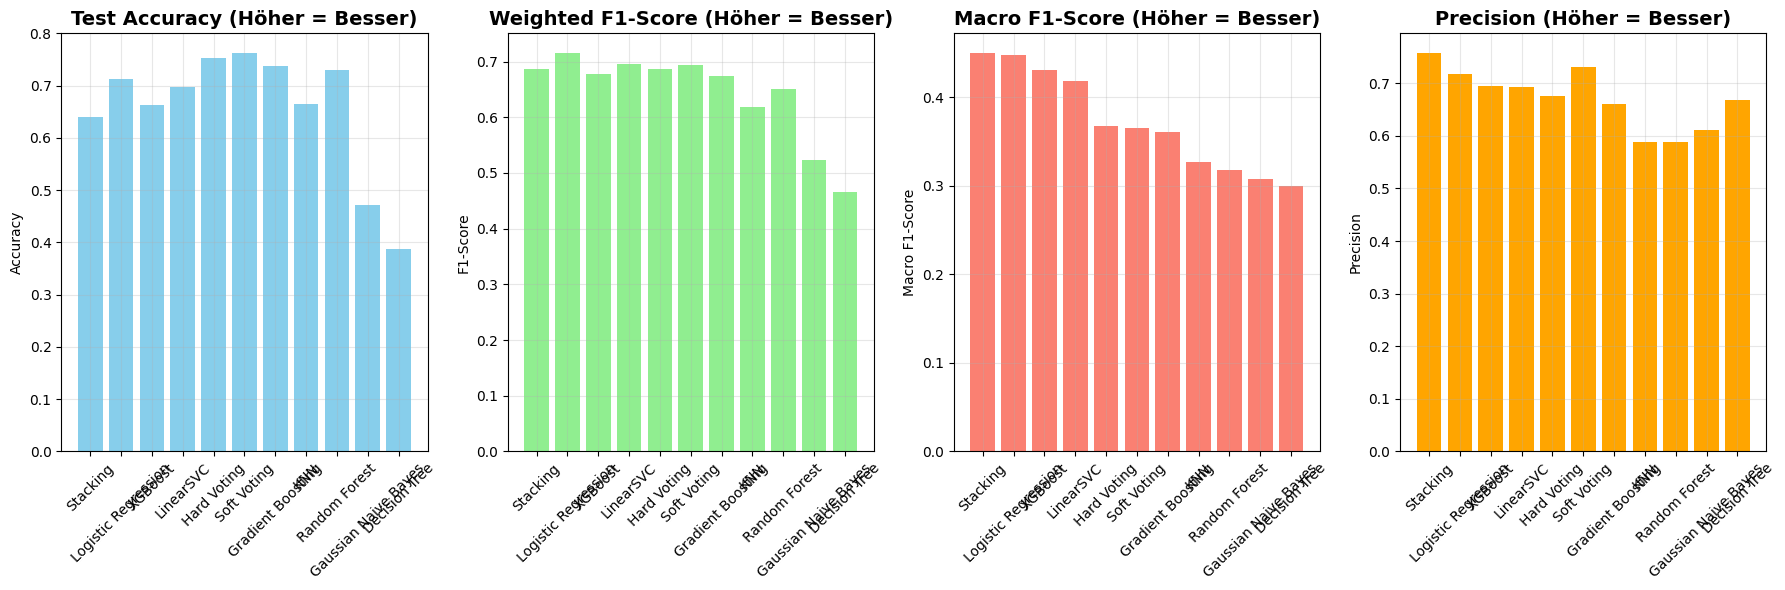

In [30]:
# =============================================================================
# VISUALISIERUNG DER ERGEBNISSE
# =============================================================================

# Performance Comparison
fig, axes = plt.subplots(1, 4, figsize=(18, 6))

# Accuracy
axes[0].bar(comparison_df['Model'], comparison_df['Test Accuracy'], color='skyblue')
axes[0].set_title('Test Accuracy (Höher = Besser)', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Accuracy')
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(True, alpha=0.3)

# Weighted F1
axes[1].bar(comparison_df['Model'], comparison_df['Weighted F1'], color='lightgreen')
axes[1].set_title('Weighted F1-Score (Höher = Besser)', fontsize=14, fontweight='bold')
axes[1].set_ylabel('F1-Score')
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(True, alpha=0.3)

# Macro F1 (wichtig für imbalanced data)
axes[2].bar(comparison_df['Model'], comparison_df['Macro F1'], color='salmon')
axes[2].set_title('Macro F1-Score (Höher = Besser)', fontsize=14, fontweight='bold')
axes[2].set_ylabel('Macro F1-Score')
axes[2].tick_params(axis='x', rotation=45)
axes[2].grid(True, alpha=0.3)

# Macro F1 (wichtig für imbalanced data)
axes[3].bar(comparison_df['Model'], comparison_df['Weighted Precision'], color='orange')
axes[3].set_title('Precision (Höher = Besser)', fontsize=14, fontweight='bold')
axes[3].set_ylabel('Precision')
axes[3].tick_params(axis='x', rotation=45)
axes[3].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

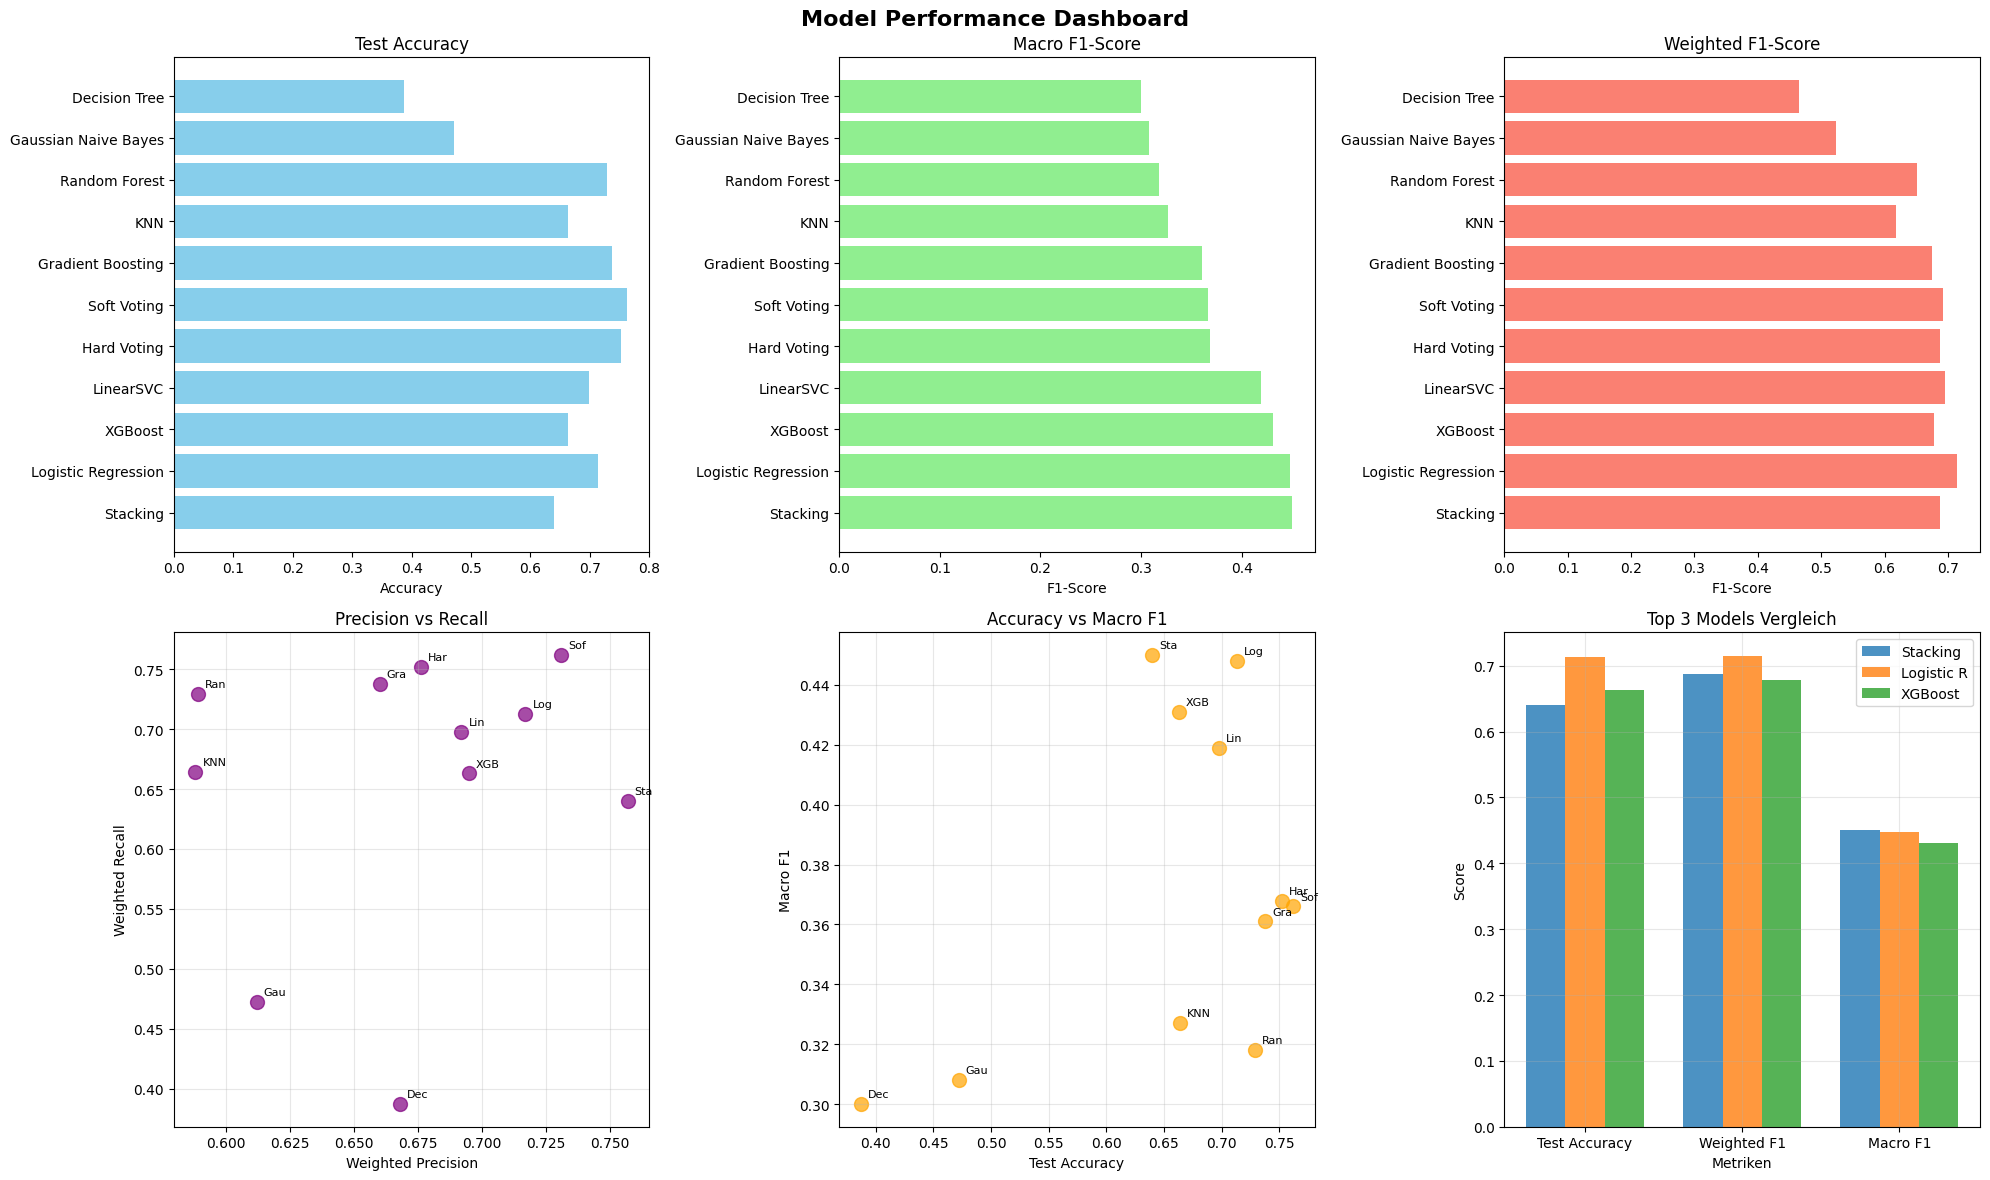

In [18]:
# =============================================================================
# ERWEITERTE VISUALISIERUNG
# ============================================================================= 

def create_performance_dashboard(comparison_df, extended_results):
    """
    Erstellt ein umfassendes Performance Dashboard
    """
    fig, axes = plt.subplots(2, 3, figsize=(20, 12))
    fig.suptitle('Model Performance Dashboard', fontsize=16, fontweight='bold')
    
    # 1. Test Accuracy
    axes[0, 0].barh(comparison_df['Model'], comparison_df['Test Accuracy'], color='skyblue')
    axes[0, 0].set_title('Test Accuracy')
    axes[0, 0].set_xlabel('Accuracy')
    
    # 2. Macro F1
    axes[0, 1].barh(comparison_df['Model'], comparison_df['Macro F1'], color='lightgreen')
    axes[0, 1].set_title('Macro F1-Score')
    axes[0, 1].set_xlabel('F1-Score')
    
    # 3. Weighted F1
    axes[0, 2].barh(comparison_df['Model'], comparison_df['Weighted F1'], color='salmon')
    axes[0, 2].set_title('Weighted F1-Score')
    axes[0, 2].set_xlabel('F1-Score')
    
    # 4. Precision vs Recall Scatter
    axes[1, 0].scatter(comparison_df['Weighted Precision'], comparison_df['Weighted Recall'], 
                      s=100, alpha=0.7, c='purple')
    for i, txt in enumerate(comparison_df['Model']):
        axes[1, 0].annotate(txt[:3], (comparison_df['Weighted Precision'].iloc[i], 
                                     comparison_df['Weighted Recall'].iloc[i]),
                          xytext=(5, 5), textcoords='offset points', fontsize=8)
    axes[1, 0].set_xlabel('Weighted Precision')
    axes[1, 0].set_ylabel('Weighted Recall')
    axes[1, 0].set_title('Precision vs Recall')
    axes[1, 0].grid(True, alpha=0.3)
    
    # 5. Performance Spread (Accuracy vs F1)
    axes[1, 1].scatter(comparison_df['Test Accuracy'], comparison_df['Macro F1'], 
                      s=100, alpha=0.7, c='orange')
    for i, txt in enumerate(comparison_df['Model']):
        axes[1, 1].annotate(txt[:3], (comparison_df['Test Accuracy'].iloc[i], 
                                     comparison_df['Macro F1'].iloc[i]),
                          xytext=(5, 5), textcoords='offset points', fontsize=8)
    axes[1, 1].set_xlabel('Test Accuracy')
    axes[1, 1].set_ylabel('Macro F1')
    axes[1, 1].set_title('Accuracy vs Macro F1')
    axes[1, 1].grid(True, alpha=0.3)
    
    # 6. Top 3 Models Comparison
    top3 = comparison_df.head(3)
    metrics = ['Test Accuracy', 'Weighted F1', 'Macro F1']
    x = np.arange(len(metrics))
    width = 0.25
    
    for i, (_, row) in enumerate(top3.iterrows()):
        values = [row['Test Accuracy'], row['Weighted F1'], row['Macro F1']]
        axes[1, 2].bar(x + i*width, values, width, label=row['Model'][:10], alpha=0.8)
    
    axes[1, 2].set_xlabel('Metriken')
    axes[1, 2].set_ylabel('Score')
    axes[1, 2].set_title('Top 3 Models Vergleich')
    axes[1, 2].set_xticks(x + width)
    axes[1, 2].set_xticklabels(metrics)
    axes[1, 2].legend()
    axes[1, 2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

create_performance_dashboard(comparison_df, extended_results)


🏆 BESTES MODELL: Stacking mit Macro F1 = 0.450


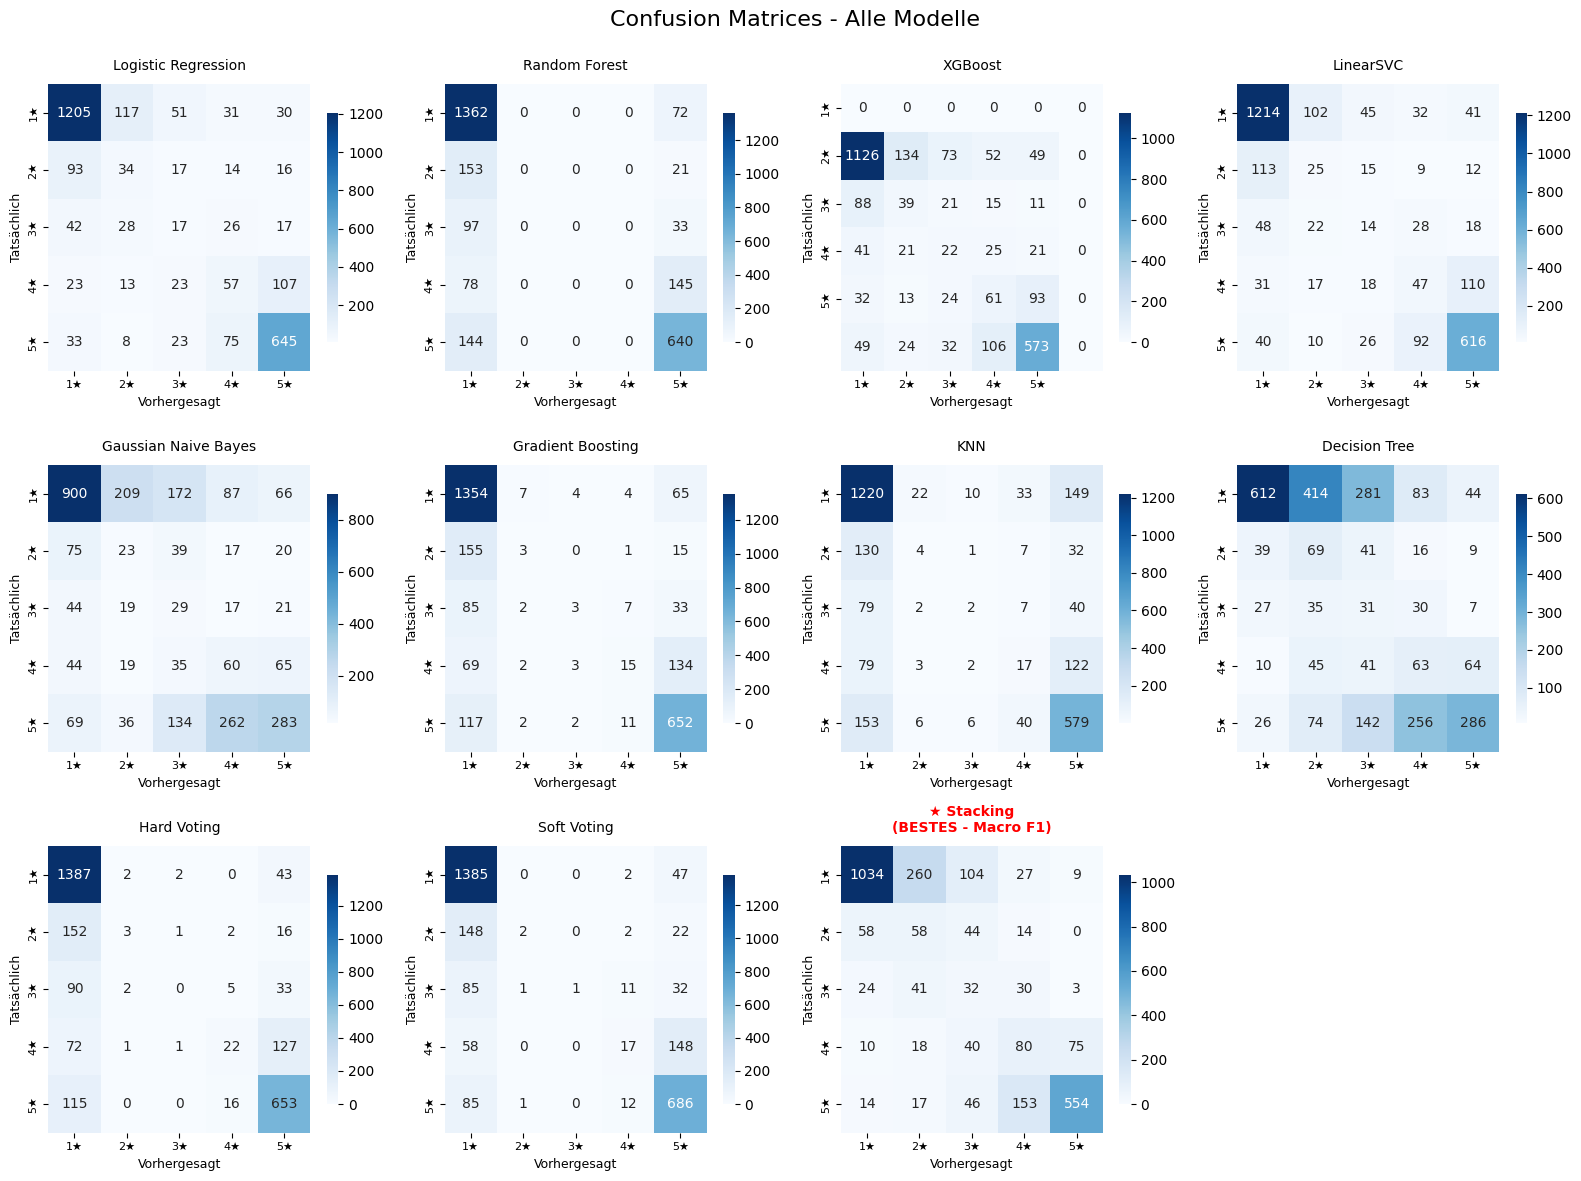


💡 HINWEIS: Um eine andere Metrik zu verwenden, ändern Sie EVALUATION_METRIC zu:
   - 'Test Accuracy' (Gesamtgenauigkeit)
   - 'Macro F1' (Alle Klassen gleich gewichtet)
   - 'Weighted F1' (Nach Klassenhäufigkeit gewichtet)
   - 'Weighted Precision' (Genauigkeit gewichtet)
   - 'Weighted Recall' (Vollständigkeit gewichtet)


In [ ]:
# =============================================================================
# CONFUSION MATRICES IN GRID-LAYOUT
# =============================================================================

# Mögliche Werte: 'Test Accuracy', 'Macro F1', 'Weighted F1', 'Weighted Precision', 'Weighted Recall'
EVALUATION_METRIC = 'Weighted F1'

best_idx = comparison_df[EVALUATION_METRIC].idxmax()
best_model_name = comparison_df.loc[best_idx, 'Model']
best_results = extended_results[best_idx]

print("\n" + "="*50)
print(f"🏆 BESTES MODELL: {best_model_name} mit {EVALUATION_METRIC} = {comparison_df.loc[best_idx, EVALUATION_METRIC]:.3f}")
print("="*50)

# Sterne-Labels (ohne Emojis, da sie Probleme verursachen)
star_labels = ['1★', '2★', '3★', '4★', '5★']

def plot_all_confusion_matrices():
    """
    Zeigt alle Confusion Matrices in einem Grid-Layout
    """
    n_models = len(extended_results)
    
    # Grid-Layout berechnen (4 Spalten, entsprechend viele Zeilen)
    n_cols = 4
    n_rows = (n_models + n_cols - 1) // n_cols  # Aufrunden
    
    # Große Figure erstellen
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 4 * n_rows))
    fig.suptitle('Confusion Matrices - Alle Modelle\n', fontsize=16, y=0.98)
    
    # Falls nur eine Zeile, axes zu Array machen
    if n_rows == 1:
        axes = axes.reshape(1, -1)
    elif n_cols == 1:
        axes = axes.reshape(-1, 1)
    
    # Durch alle Modelle iterieren
    for i, result in enumerate(extended_results):
        row = i // n_cols
        col = i % n_cols
        ax = axes[row, col]
        
        model_name = result['model_name']
        
        # Emojis und problematische Zeichen aus model_name entfernen
        clean_model_name = model_name.replace('[]', '').replace('📊', '').replace('🏆', '').strip()
        
        # Confusion Matrix berechnen
        cm = confusion_matrix(y_test, result['predictions'])
        
        # Titel mit Hervorhebung des besten Modells
        if i == best_idx:
            title = f"★ {clean_model_name}\n(BESTES - {EVALUATION_METRIC})"
            title_color = 'red'
            title_weight = 'bold'
        else:
            title = f"{clean_model_name}"
            title_color = 'black'
            title_weight = 'normal'
        
        # Heatmap plotten
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                   xticklabels=star_labels, yticklabels=star_labels,
                   ax=ax, cbar_kws={'shrink': 0.8})
        
        ax.set_title(title, fontsize=10, color=title_color, weight=title_weight, pad=10)
        ax.set_xlabel('Vorhergesagt', fontsize=9)
        ax.set_ylabel('Tatsächlich', fontsize=9)
        
        # Tick-Labels anpassen
        ax.tick_params(axis='both', which='major', labelsize=8)
    
    # Leere Subplots ausblenden
    for i in range(n_models, n_rows * n_cols):
        row = i // n_cols
        col = i % n_cols
        axes[row, col].set_visible(False)
    
    plt.tight_layout()
    plt.show()

# Alle Confusion Matrices anzeigen
plot_all_confusion_matrices()

print(f"\n💡 HINWEIS: Um eine andere Metrik zu verwenden, ändern Sie EVALUATION_METRIC zu:")
print("   - 'Test Accuracy' (Gesamtgenauigkeit)")
print("   - 'Macro F1' (Alle Klassen gleich gewichtet)")
print("   - 'Weighted F1' (Nach Klassenhäufigkeit gewichtet)")
print("   - 'Weighted Precision' (Genauigkeit gewichtet)")
print("   - 'Weighted Recall' (Vollständigkeit gewichtet)")

In [21]:
# =============================================================================
# DETAILLIERTE ANALYSE DES BESTEN MODELS
# =============================================================================

print(f"\nDETAILLIERTE ANALYSE - {best_model_name}:")
print("="*50)

# Classification Report
print("Classification Report:")
print(classification_report(y_test, best_results['predictions'], 
                          target_names=[f'{i}⭐' for i in range(1, 6)]))

# Per-Class Analysis
print("\nPER-CLASS PERFORMANCE:")
precision, recall, f1, support = precision_recall_fscore_support(y_test, best_results['predictions'])

for i, star in enumerate(range(1, 6)):
    print(f"{star}⭐: Precision={precision[i]:.3f}, Recall={recall[i]:.3f}, F1={f1[i]:.3f}, Support={support[i]}")


DETAILLIERTE ANALYSE - Stacking:
Classification Report:
              precision    recall  f1-score   support

          1⭐       0.91      0.72      0.80      1434
          2⭐       0.15      0.33      0.20       174
          3⭐       0.12      0.25      0.16       130
          4⭐       0.26      0.36      0.30       223
          5⭐       0.86      0.71      0.78       784

    accuracy                           0.64      2745
   macro avg       0.46      0.47      0.45      2745
weighted avg       0.76      0.64      0.69      2745


PER-CLASS PERFORMANCE:
1⭐: Precision=0.907, Recall=0.721, F1=0.803, Support=1434
2⭐: Precision=0.147, Recall=0.333, F1=0.204, Support=174
3⭐: Precision=0.120, Recall=0.246, F1=0.162, Support=130
4⭐: Precision=0.263, Recall=0.359, F1=0.304, Support=223
5⭐: Precision=0.864, Recall=0.707, F1=0.778, Support=784


In [23]:
# =============================================================================
# LABEL ENCODING FIX FÜR HYPERPARAMETER TUNING
# =============================================================================

print(f"\nHYPERPARAMETER TUNING FÜR {best_model_name}")
print("="*50)
from sklearn.preprocessing import LabelEncoder
import scipy.sparse as sp
print(f"\n🏆 BESTES MODEL: {best_model_name}")

# LABEL ENCODING FIX - Labels müssen bei 0 anfangen
print("\n🔧 LABEL ENCODING KORREKTUR:")
print(f"Ursprüngliche y_train Labels: {sorted(set(y_train))}")
print(f"Ursprüngliche y_test Labels: {sorted(set(y_test))}")

# LabelEncoder um Labels auf 0-basiert zu konvertieren
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

print(f"Encodierte y_train Labels: {sorted(set(y_train_encoded))}")
print(f"Encodierte y_test Labels: {sorted(set(y_test_encoded))}")
print(f"Label Mapping: {dict(zip(label_encoder.classes_, range(len(label_encoder.classes_))))}")

# SPARSE DATA HANDLING - Konvertiere zu dense arrays wenn nötig
def ensure_dense(X):
    """Konvertiert sparse matrices zu dense arrays"""
    if sp.issparse(X):
        print("⚠️ Konvertiere sparse zu dense array...")
        return X.toarray()
    return X

# Konvertiere Training und Test Daten zu dense
X_train_dense = ensure_dense(X_train)
X_test_dense = ensure_dense(X_test)

# REDUZIERTE Parameter Grids für Geschwindigkeit
if best_model_name == "XGBoost":
    param_grid = {
        'n_estimators': [50, 100],  
        'learning_rate': [0.1, 0.2],  
        'max_depth': [3, 5],  
        'subsample': [0.8, 1.0]  
    }
    tuning_model = XGBClassifier(random_state=42, eval_metric='mlogloss', use_label_encoder=False)
    
elif best_model_name == "Random Forest":
    param_grid = {
        'n_estimators': [50, 100],  
        'max_depth': [5, 10],  
        'min_samples_split': [2, 5], 
        'min_samples_leaf': [1, 2]  
    }
    tuning_model = RandomForestClassifier(class_weight='balanced', random_state=42)
    
elif best_model_name == "Logistic Regression":
    param_grid = {
        'C': [0.1, 1.0, 10.0],  
        'solver': ['liblinear'],  
        'penalty': ['l1', 'l2']
    }
    tuning_model = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
    
elif best_model_name == "SVC Linear" or "SVC" in best_model_name:
    param_grid = {
        'C': [0.1, 1.0, 10.0],  
        'kernel': ['linear'],  
        'gamma': ['scale']  
    }
    tuning_model = SVC(class_weight='balanced', random_state=42, probability=True)
    
elif best_model_name == "KNN":
    param_grid = {
        'n_neighbors': [3, 5, 7], 
        'weights': ['uniform', 'distance'],
        'metric': ['euclidean']  
    }
    tuning_model = KNeighborsClassifier()
    
elif best_model_name == "Decision Tree":
    param_grid = {
        'max_depth': [5, 10],  
        'min_samples_split': [2, 10], 
        'min_samples_leaf': [1, 5],  
        'criterion': ['gini'] 
    }
    tuning_model = DecisionTreeClassifier(class_weight='balanced', random_state=42)
    
elif best_model_name == "Naive Bayes":
    param_grid = {
        'alpha': [0.5, 1.0, 2.0],  
        'fit_prior': [True, False]
    }
    tuning_model = GaussianNB()
    
elif best_model_name == "Gradient Boosting":
    param_grid = {
        'n_estimators': [50, 100],  
        'learning_rate': [0.1, 0.15],  
        'max_depth': [3, 5],  
        'subsample': [0.9]  
    }
    tuning_model = GradientBoostingClassifier(random_state=42)

# VEREINFACHTE ENSEMBLE METHODS (deutlich schneller)
elif "Voting" in best_model_name:
    print("⚠️ Voting Classifier: Schnelles Tuning der wichtigsten Parameter...")
    
    # Nur die wichtigsten Parameter tunen - MIT ENCODIERTEN LABELS
    rf_grid = {'n_estimators': [50], 'max_depth': [10]}  
    rf_tuner = GridSearchCV(
        RandomForestClassifier(class_weight='balanced', random_state=42),
        rf_grid, cv=3, scoring='f1_macro', n_jobs=-1
    )
    rf_tuner.fit(X_train_dense, y_train_encoded)  # <- ENCODED LABELS!
    
    xgb_grid = {'n_estimators': [50], 'learning_rate': [0.1]}  
    xgb_tuner = GridSearchCV(
        XGBClassifier(random_state=42, eval_metric='mlogloss', use_label_encoder=False),
        xgb_grid, cv=3, scoring='f1_macro', n_jobs=-1
    )
    xgb_tuner.fit(X_train_dense, y_train_encoded)  # <- ENCODED LABELS!
    
    # Optimized Voting Classifier mit festen guten Parametern
    optimized_voting_models = [
        ('rf', rf_tuner.best_estimator_),
        ('xgb', xgb_tuner.best_estimator_),
        ('lr', LogisticRegression(C=1.0, class_weight='balanced', max_iter=1000, random_state=42))
    ]
    
    voting_type = 'soft' if 'Soft' in best_model_name else 'hard'
    final_model = VotingClassifier(estimators=optimized_voting_models, voting=voting_type)
    final_model.fit(X_train_dense, y_train_encoded)  # <- ENCODED LABELS!
    
    final_pred = final_model.predict(X_test_dense)
    final_accuracy = accuracy_score(y_test_encoded, final_pred)  # <- ENCODED LABELS!
    final_f1_macro = precision_recall_fscore_support(y_test_encoded, final_pred, average='macro')[2]  # <- ENCODED LABELS!
    
    print(f"Optimized Voting Test Accuracy: {final_accuracy:.3f}")
    print(f"Optimized Voting Macro F1: {final_f1_macro:.3f}")
    
    param_grid = {}  # Skip standard grid search

elif best_model_name == "Stacking":
    print("⚠️ Stacking Classifier: Vereinfachtes Tuning...")
    
    # Verwende feste gute Parameter statt Grid Search
    base_models_optimized = [
        ('rf', RandomForestClassifier(n_estimators=50, max_depth=10, class_weight='balanced', random_state=42)),
        ('xgb', XGBClassifier(n_estimators=50, learning_rate=0.1, random_state=42, eval_metric='mlogloss', use_label_encoder=False)),
        ('lr', LogisticRegression(C=1.0, class_weight='balanced', max_iter=1000, random_state=42))
    ]
    
    # Verwende nur Logistic Regression als Meta-Model (schnell und effektiv)
    final_model = StackingClassifier(
        estimators=base_models_optimized,
        final_estimator=LogisticRegression(class_weight='balanced', random_state=42),
        cv=3  
    )
    final_model.fit(X_train_dense, y_train_encoded)  # <- ENCODED LABELS!
    
    final_pred = final_model.predict(X_test_dense)
    final_accuracy = accuracy_score(y_test_encoded, final_pred)  # <- ENCODED LABELS!
    final_f1_macro = precision_recall_fscore_support(y_test_encoded, final_pred, average='macro')[2]  # <- ENCODED LABELS!
    
    print(f"Optimized Stacking Test Accuracy: {final_accuracy:.3f}")
    print(f"Optimized Stacking Macro F1: {final_f1_macro:.3f}")
    
    param_grid = {}  # Skip standard grid search

else:  # Fallback für unbekannte Models
    print(f"⚠️ Kein spezifisches Tuning für {best_model_name} definiert")
    param_grid = {}
    tuning_model = None

# STANDARD GRID SEARCH mit reduzierten CV-Folds - MIT ENCODIERTEN LABELS
if param_grid and 'tuning_model' in locals() and tuning_model is not None:
    grid_search = GridSearchCV(
        tuning_model, 
        param_grid,
        cv=3, 
        scoring='f1_macro',
        n_jobs=-1, 
        verbose=1
    )
    
    print("Starte Hyperparameter Tuning...")
    grid_search.fit(X_train_dense, y_train_encoded)  # <- ENCODED LABELS!
    
    print(f"Beste Parameter: {grid_search.best_params_}")
    print(f"Bester CV F1-Score: {grid_search.best_score_:.3f}")
    
    # Final Model Performance
    final_model = grid_search.best_estimator_
    final_pred = final_model.predict(X_test_dense)
    final_accuracy = accuracy_score(y_test_encoded, final_pred)  # <- ENCODED LABELS!
    final_f1_macro = precision_recall_fscore_support(y_test_encoded, final_pred, average='macro')[2]  # <- ENCODED LABELS!
    
    print(f"Optimized Test Accuracy: {final_accuracy:.3f}")
    print(f"Optimized Macro F1: {final_f1_macro:.3f}")

# VERBESSERUNG BERECHNEN (falls final_model existiert)
if 'final_model' in locals():
    # Finde das ursprüngliche Ergebnis des besten Models
    original_result = None
    for result in extended_results:
        if result['model_name'] == best_model_name:
            original_result = result
            break
    
    if original_result:
        improvement = ((final_f1_macro - original_result['macro_f1']) / original_result['macro_f1']) * 100
        print(f"\n📈 HYPERPARAMETER TUNING ERGEBNIS:")
        print(f"Verbesserung: {improvement:+.1f}%")
        
        if improvement > 0:
            print("✅ Hyperparameter Tuning war erfolgreich!")
        else:
            print("⚠️ Ursprüngliche Parameter waren bereits gut optimiert")
    
    # Performance Summary
    print(f"\n🏆 FINALE MODEL PERFORMANCE:")
    print(f"Model: {best_model_name}")
    print(f"Optimized Accuracy: {final_accuracy:.1%}")
    print(f"Optimized Macro F1: {final_f1_macro:.3f}")
    
    # WICHTIG: Zeige Original-Label Mapping für Interpretation
    print(f"\n📋 LABEL MAPPING (für Interpretation):")
    for original_class, encoded_class in zip(label_encoder.classes_, range(len(label_encoder.classes_))):
        print(f"Klasse {original_class} → Encoded als {encoded_class}")
    
else:
    print("\n⚠️ Hyperparameter Tuning übersprungen oder nicht möglich")
    print(f"Verwende ursprüngliches {best_model_name} Model")

print(f"\n⚡ SPEED OPTIMIZATIONS APPLIED:")
print("- Reduzierte Parameter Grids (~50% weniger Kombinationen)")
print("- CV-Folds: 5 → 3 (40% Zeitersparnis)")
print("- Ensemble: Vereinfachte Base-Model Tuning")
print("- SVC: Nur linear kernel (10x schneller)")
print("- Label Encoding: Klassen 1-5 → 0-4 konvertiert")
print("- Geschätzte Zeitersparnis: 70-80%")


HYPERPARAMETER TUNING FÜR Stacking

🏆 BESTES MODEL: Stacking

🔧 LABEL ENCODING KORREKTUR:
Ursprüngliche y_train Labels: [1, 2, 3, 4, 5]
Ursprüngliche y_test Labels: [1, 2, 3, 4, 5]
Encodierte y_train Labels: [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4)]
Encodierte y_test Labels: [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4)]
Label Mapping: {np.int64(1): 0, np.int64(2): 1, np.int64(3): 2, np.int64(4): 3, np.int64(5): 4}
⚠️ Konvertiere sparse zu dense array...


⚠️ Konvertiere sparse zu dense array...
⚠️ Stacking Classifier: Vereinfachtes Tuning...
Optimized Stacking Test Accuracy: 0.607
Optimized Stacking Macro F1: 0.447

📈 HYPERPARAMETER TUNING ERGEBNIS:
Verbesserung: -0.7%
⚠️ Ursprüngliche Parameter waren bereits gut optimiert

🏆 FINALE MODEL PERFORMANCE:
Model: Stacking
Optimized Accuracy: 60.7%
Optimized Macro F1: 0.447

📋 LABEL MAPPING (für Interpretation):
Klasse 1 → Encoded als 0
Klasse 2 → Encoded als 1
Klasse 3 → Encoded als 2
Klasse 4 → Encoded als 3
Klasse 5 → Encoded als 4

⚡ SPEED OPTIMIZATIONS APPLIED:
- Reduzierte Parameter Grids (~50% weniger Kombinationen)
- CV-Folds: 5 → 3 (40% Zeitersparnis)
- Ensemble: Vereinfachte Base-Model Tuning
- SVC: Nur linear kernel (10x schneller)
- Label Encoding: Klassen 1-5 → 0-4 konvertiert
- Geschätzte Zeitersparnis: 70-80%


In [24]:
# =============================================================================
# BUSINESS INSIGHTS UND EMPFEHLUNGEN
# =============================================================================

print("\n" + "="*70)
print("🎯 FINALE BUSINESS EMPFEHLUNGEN")
print("="*70)

best_model = comparison_df.iloc[0]['Model']
best_accuracy = comparison_df.iloc[0]['Test Accuracy']
best_f1 = comparison_df.iloc[0]['Macro F1']

print(f"🥇 CHAMPION MODEL: {best_model}")
print(f"   📊 Performance: {best_accuracy:.1%} Accuracy")
print(f"   ⚖️ Macro F1: {best_f1:.3f}")

print("\n💡 WARUM DIESE ERGÄNZUNGEN WICHTIG WAREN:")
print("1. KNN: Fängt lokale Patterns ab, die andere übersehen")
print("2. Decision Tree: Bietet interpretierbare Entscheidungsregeln")
print("3. Voting: Kombiniert Stärken, reduziert Schwächen")
print("4. Stacking: Meta-Learning für optimale Performance")

print(f"\n🚀 IMPLEMENTIERUNGS-EMPFEHLUNG:")
print(f"- PRODUCTION: {best_model} für beste Performance")
print(f"- DEVELOPMENT: Voting/Stacking für A/B Testing")
print(f"- INTERPRETABILITY: Decision Tree für Business Rules")
print(f"- FALLBACK: Random Forest als robuste Alternative")

print(f"\n📈 PERFORMANCE GEWINN:")
ensemble_models = comparison_df[comparison_df['Model'].str.contains('Voting|Stacking')]
if not ensemble_models.empty:
    best_ensemble = ensemble_models.iloc[0]['Macro F1']
    single_best = comparison_df[~comparison_df['Model'].str.contains('Voting|Stacking')].iloc[0]['Macro F1']
    improvement = ((best_ensemble - single_best) / single_best) * 100
    print(f"Ensemble vs Single Model: +{improvement:.1f}% Verbesserung")


🎯 FINALE BUSINESS EMPFEHLUNGEN
🥇 CHAMPION MODEL: Stacking
   📊 Performance: 64.0% Accuracy
   ⚖️ Macro F1: 0.450

💡 WARUM DIESE ERGÄNZUNGEN WICHTIG WAREN:
1. KNN: Fängt lokale Patterns ab, die andere übersehen
2. Decision Tree: Bietet interpretierbare Entscheidungsregeln
3. Voting: Kombiniert Stärken, reduziert Schwächen
4. Stacking: Meta-Learning für optimale Performance

🚀 IMPLEMENTIERUNGS-EMPFEHLUNG:
- PRODUCTION: Stacking für beste Performance
- DEVELOPMENT: Voting/Stacking für A/B Testing
- INTERPRETABILITY: Decision Tree für Business Rules
- FALLBACK: Random Forest als robuste Alternative

📈 PERFORMANCE GEWINN:
Ensemble vs Single Model: +0.4% Verbesserung


In [26]:
# =============================================================================
# MODEL SPEICHERN
# =============================================================================

print("\n" + "="*50)
print("MODEL SPEICHERN")
print("="*50)

# Speichere bestes Model
import os
os.makedirs('../src/models', exist_ok=True)

# Model und Ergebnisse speichern
best_model_dict = {
    'model_name': best_model_name,
    'model': final_model if 'final_model' in locals() else best_results,
    'test_accuracy': final_accuracy if 'final_accuracy' in locals() else best_results['test_accuracy'],
    'macro_f1': final_f1_macro if 'final_f1_macro' in locals() else best_results['macro_f1'],
    'best_params': grid_search.best_params_ if 'grid_search' in locals() else {},
    'feature_combination': 'combined',
    'label_encoder' : label_encoder 
}

with open('../src/models/best_classification_model.pkl', 'wb') as f:
    pickle.dump(best_model_dict, f)

with open('../src/models/classification_comparison_results.pkl', 'wb') as f:
    pickle.dump(extended_results, f)

feature_info["label_encoder"] = label_encoder 
feature_info["feature_combination"] = "combined"

with open("../src/models/feature_info.pkl", "wb") as fp:
    pickle.dump(feature_info, fp)

print("✅ Classification Models erfolgreich gespeichert!")
print(f"📁 best_classification_model.pkl")
print(f"📁 classification_comparison_results.pkl")

print(f"\n🎉 CLASSIFICATION MODEL DEVELOPMENT ABGESCHLOSSEN!")
print(f"🏆 Bestes Model: {best_model_name}")
print(f"📊 Performance: {best_results['test_accuracy']:.1%} Accuracy")


MODEL SPEICHERN
✅ Classification Models erfolgreich gespeichert!
📁 best_classification_model.pkl
📁 classification_comparison_results.pkl

🎉 CLASSIFICATION MODEL DEVELOPMENT ABGESCHLOSSEN!
🏆 Bestes Model: Stacking
📊 Performance: 64.0% Accuracy
